In [35]:
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class EvaluateMetrics:
    def __init__(
        self, data_dir="~/.cache/models/results/data", plots_dir="~/.cache/models/results/plots"
    ):
        self.data_dir = os.path.expanduser(data_dir)
        self.plots_dir = os.path.expanduser(plots_dir)
        self.metrics = [
            "perplexity",
            "length",
            "repetition_rate",
            "distinct_2",
            "readability",
            "time_to_first_token",
            "avg_time_per_token",
            "tokens_generated",
        ]
        self.df = self.compile_csv_files_to_df()
        self.df_agg = self.save_df_agg()

        logger = logging.getLogger(__name__)

    def compile_csv_files_to_df(self):
        """Loops through a dir, collects all csv files, and compiles into a single df."""

        # Collect all csv files
        csv_files = []
        for file_name in os.listdir(self.data_dir):
            if file_name.endswith(".csv"):
                file_path = os.path.join(self.data_dir, file_name)
                csv_files.append(file_path)

        # No csv files found
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in {self.data_dir}")

        df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
        df.to_csv(os.path.join(self.plots_dir, "df.csv"), index=False)
        return df

    def save_df_agg(self):
        """Save a aggregated df with mean/std stats."""
        metrics_dict = {metric: ["mean", "std"] for metric in self.metrics}
        df_agg = self.df.groupby("model", as_index=False).agg(metrics_dict)

        # Flatten columns
        df_agg.columns = [
            "_".join(col).strip("_") if isinstance(col, tuple) else col for col in df_agg.columns
        ]

        # Save df
        df_agg.to_csv(os.path.join(self.plots_dir, "df_agg.csv"), index=False)
        return df_agg

    def plot_agg_metric(self, metric, hue="model"):
        """Plots the mean and std for a given metric with model name as the hue."""
        df_plot = self.df_agg.copy()

        # Extract relevant columns
        mean_col = f"{metric}_mean"
        std_col = f"{metric}_std"

        if mean_col not in df_plot or std_col not in df_plot:
            raise ValueError(f"Metric '{metric}' not found in the DataFrame.")

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_plot, x="model", y=mean_col, hue=hue, errorbar=None)

        # Add error bars
        for i, row in df_plot.iterrows():
            plt.errorbar(x=i, y=row[mean_col], yerr=row[std_col], fmt="none", c="black", capsize=5)

        plt.title(f"{metric.capitalize()} (Mean ± Std)", fontsize=16)
        plt.xlabel("Model", fontsize=12)
        plt.ylabel(f"{metric.capitalize()}", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title=hue, loc="upper right")
        plt.tight_layout()

        # Save or show the plot
        plt.savefig(os.path.join(self.plots_dir, f"{metric}_plot.png"))

    def plot_violin_distribution(self, metric):
        """Plots the distribution of a metric across all models using a violin plot."""
        if metric not in self.df.columns:
            raise ValueError(f"Metric '{metric}' not found in the DataFrame.")

        # Plot
        plt.figure(figsize=(12, 6))
        sns.violinplot(
            data=self.df, x="model", y=metric, palette="muted", hue="model", legend=False
        )
        plt.title(f"Violin Plot for {metric.capitalize()}", fontsize=16)
        plt.xlabel("Model", fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(self.plots_dir, f"{metric}_violin_plot.png")
        plt.savefig(plot_path)

    def plot_all_metrics(self):
        """
        Plots all specified metrics with mean and std for each model.
        """
        metrics = [
            "perplexity",
            "length",
            "repetition_rate",
            "distinct_2",
            "readability",
            "time_to_first_token",
            "avg_time_per_token",
            "tokens_generated",
        ]

        for metric in metrics:
            self.plot_violin_distribution(metric)

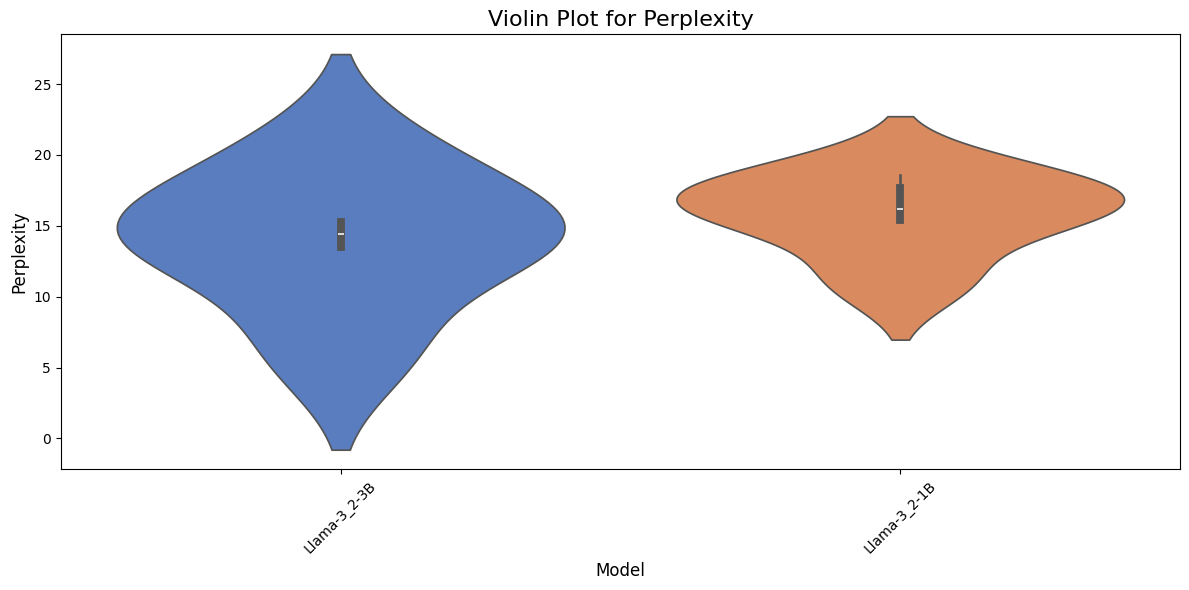

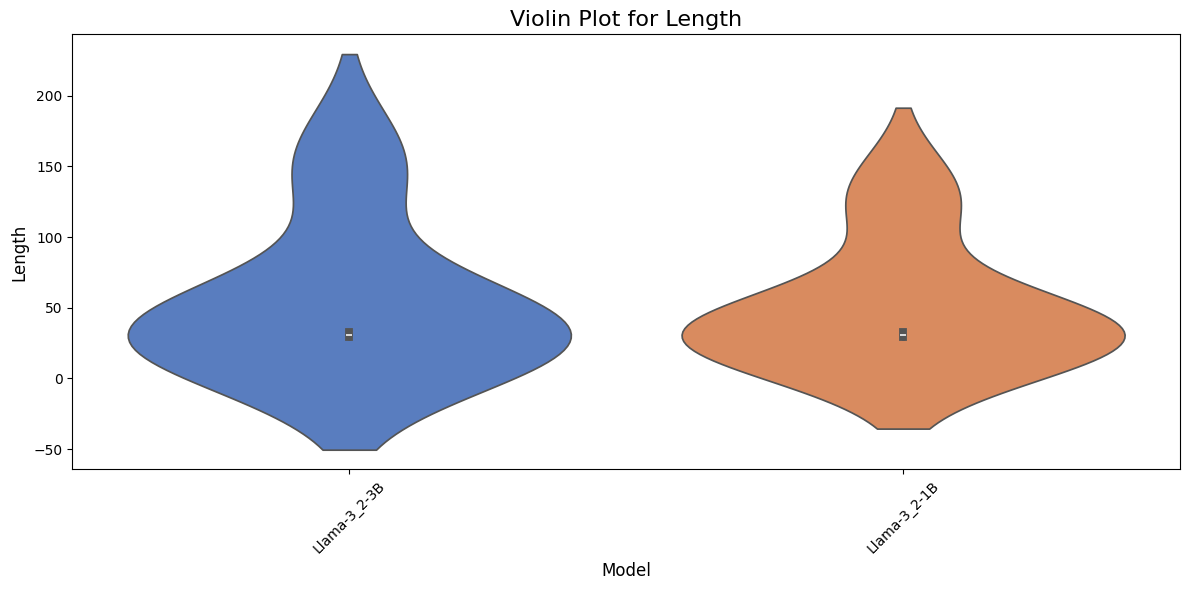

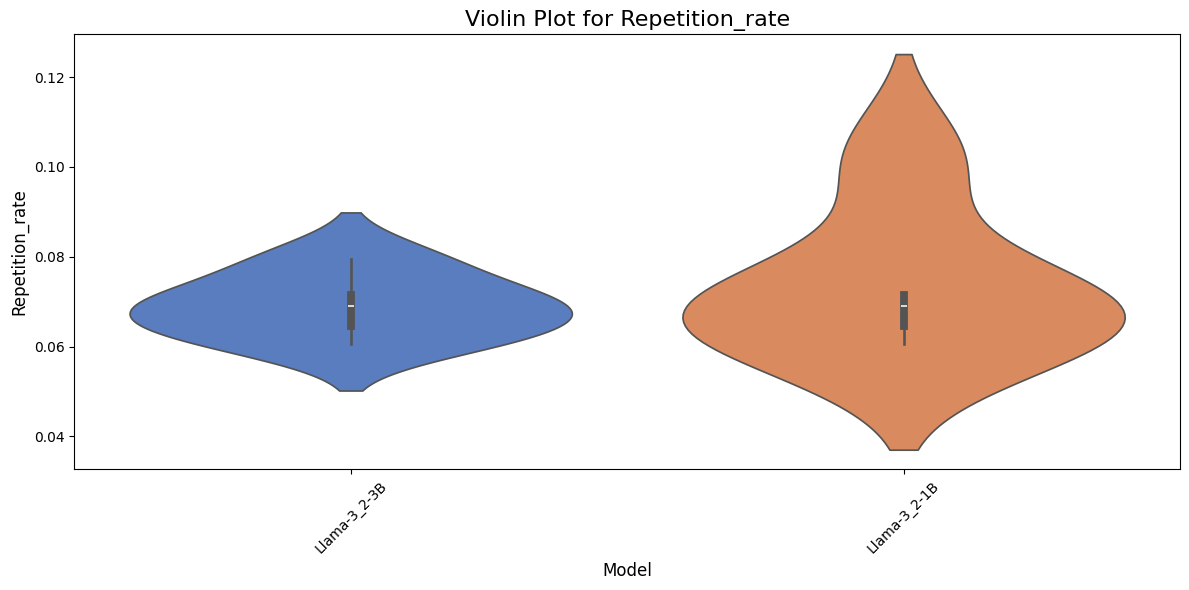

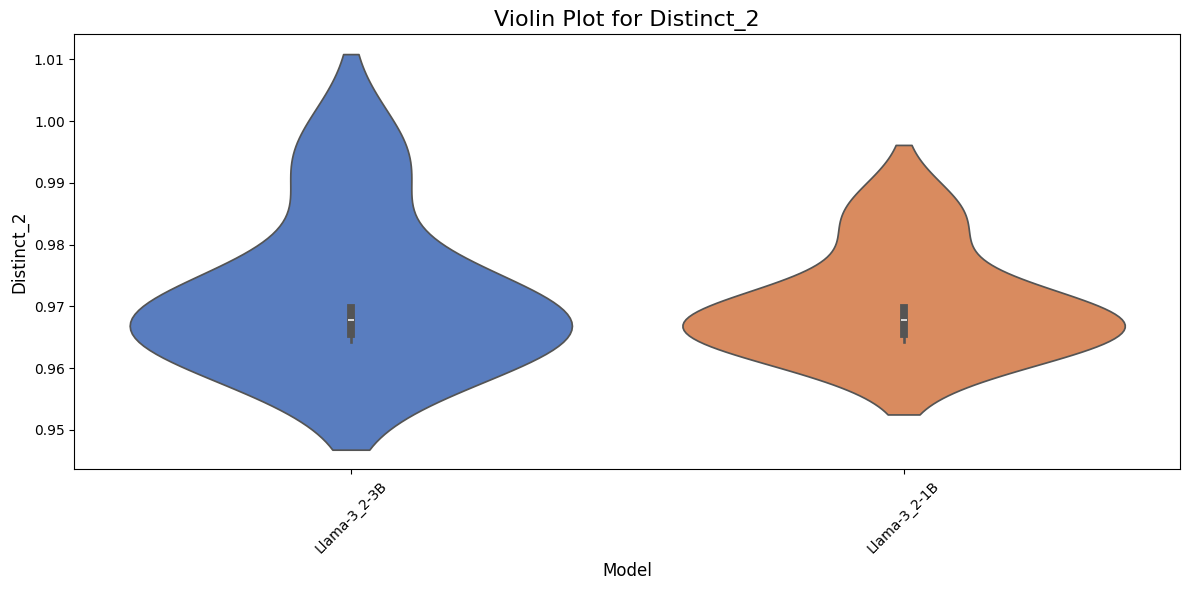

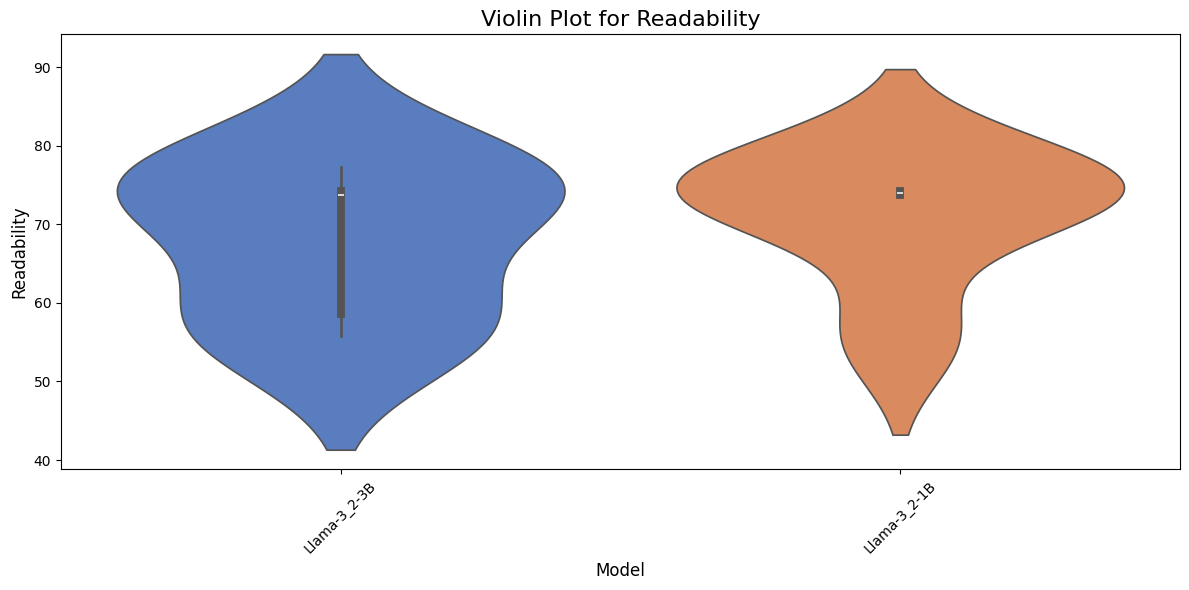

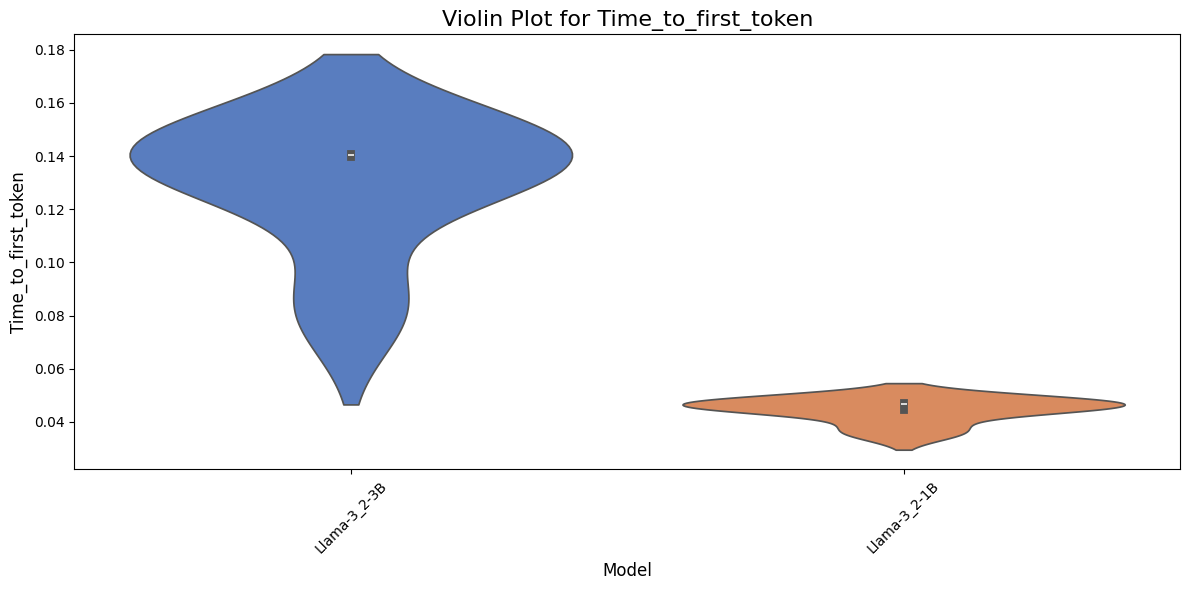

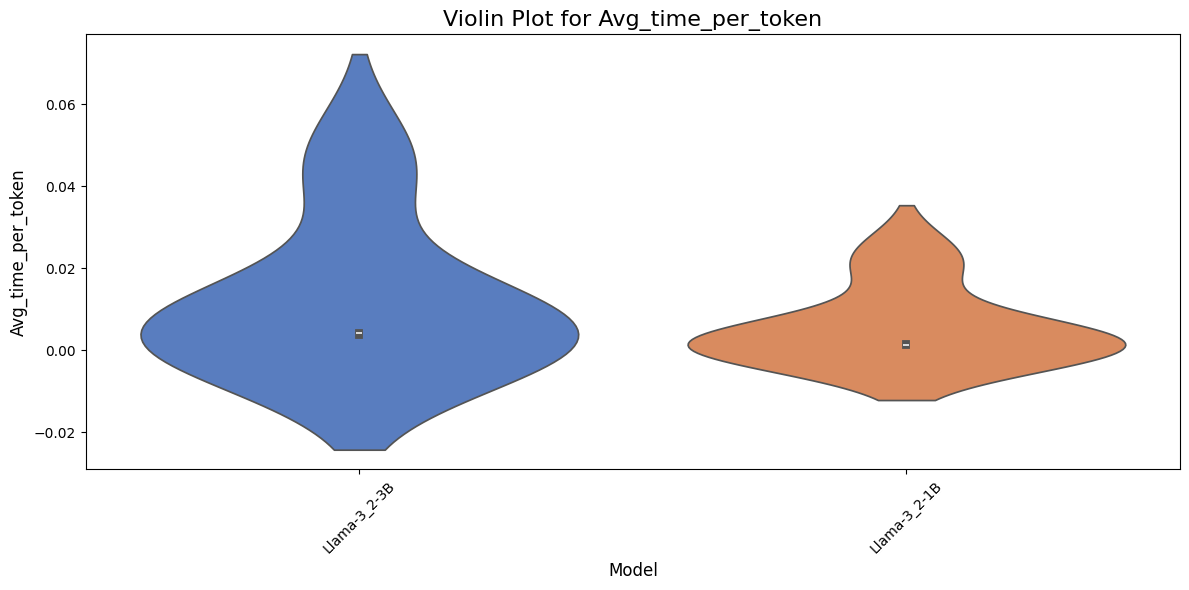

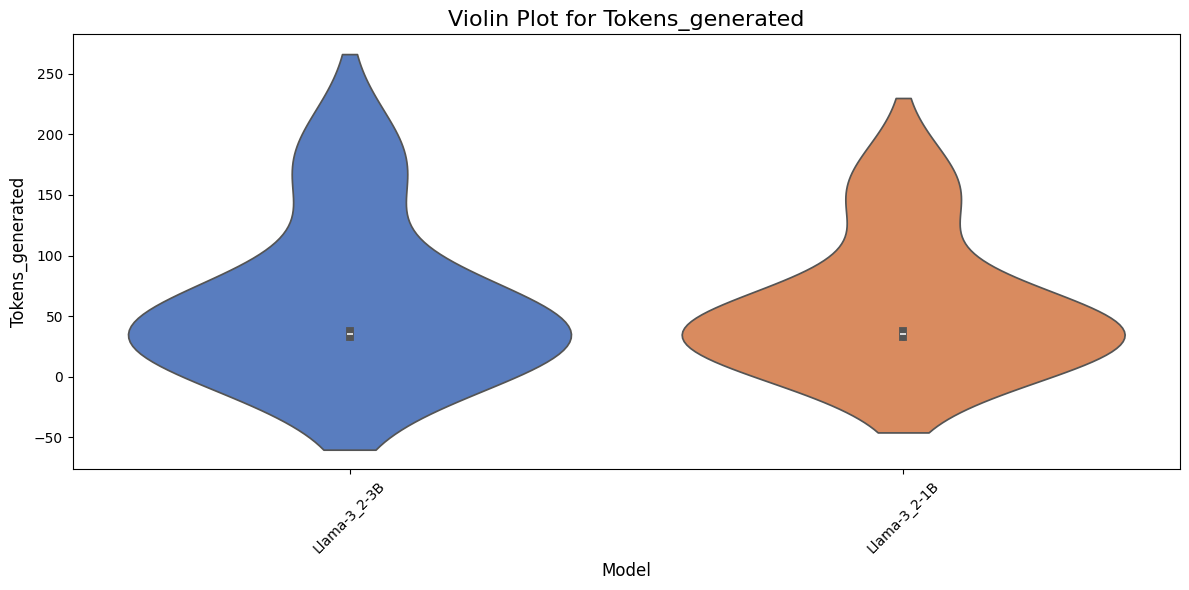

In [36]:
metrics = EvaluateMetrics()
metrics.plot_all_metrics()